# Basic imports

In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
Keras Version: 2.8.0

Python 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
Pandas 1.4.1
Scikit-Learn 1.0.2
GPU is available


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import master_functions as mf

In [3]:
df_all = pd.read_pickle('main_df.pkl')
learning_df = pd.read_csv('test/dfs&results/learning_df.tsv', sep='\t')

In [3]:
df_all.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1


In [4]:
df_all.shape

(2213180, 14)

In [4]:
X_main = df_all.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_main = df_all['y']
groups_main = df_all['group_code'].to_numpy()

# Basic MLP (multi-layer perceptron) ANN

In [7]:
learning_df = pd.read_csv('test/dfs&results/learning_df.tsv', sep='\t')
X_learning = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_learning = learning_df['y']
groups_learning = learning_df['group_code'].to_numpy()

In [6]:
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneGroupOut
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

'''
params = {
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    #'n_layers': [3],
    'hidden_layer_sizes': [(x,1) for x in range(50, 250, 50)],
    'alpha': [0.0001, 0.0005, 0.001, 0.005]
}
'''
pipe = Pipeline([
    ('normalize', Normalizer()),
    ('mlp', MLPClassifier())
])
logo = LeaveOneGroupOut()

"\nparams = {\n    'activation': ['tanh', 'relu'],\n    'solver': ['lbfgs', 'adam'],\n    #'n_layers': [3],\n    'hidden_layer_sizes': [(x,1) for x in range(50, 250, 50)],\n    'alpha': [0.0001, 0.0005, 0.001, 0.005]\n}\n"

In [8]:
results_mlp = cross_validate(pipe, X_learning, y_learning, 
    scoring='f1', cv=logo, groups=groups_learning, n_jobs=-1, return_estimator=True)

In [11]:
mlp_probs_df = mf.get_probabilities_norm(X_learning.columns, results_mlp)

In [16]:
mlp_probs_df['y'] = df_all['y']

In [17]:
mlp_probs_df.head()

,0,1,y
0,0.307815,0.692185,1
1,0.311253,0.688747,1
2,0.316004,0.683996,1
3,0.318583,0.681417,1
4,0.316084,0.683916,1


## Visualisations

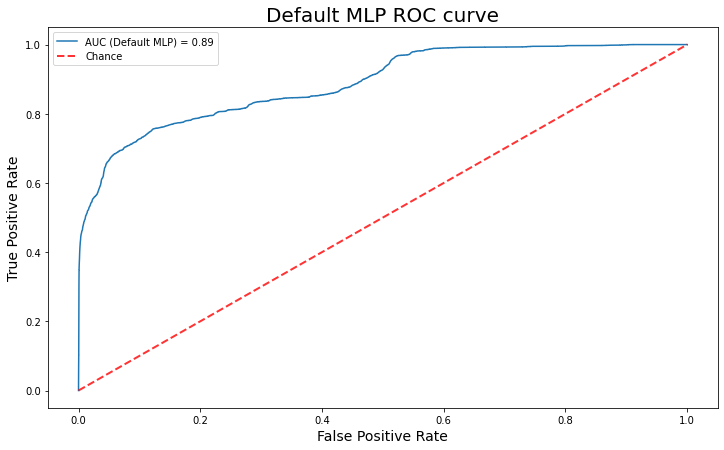

In [18]:
mf.draw_rocs([mlp_probs_df], ['Default MLP'], 'Default MLP ROC curve')

C:\Users\misia\AppData\Local\Temp\ipykernel_10224\2217512975.py:8: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = np.divide(2*recall*precision, recall+precision)


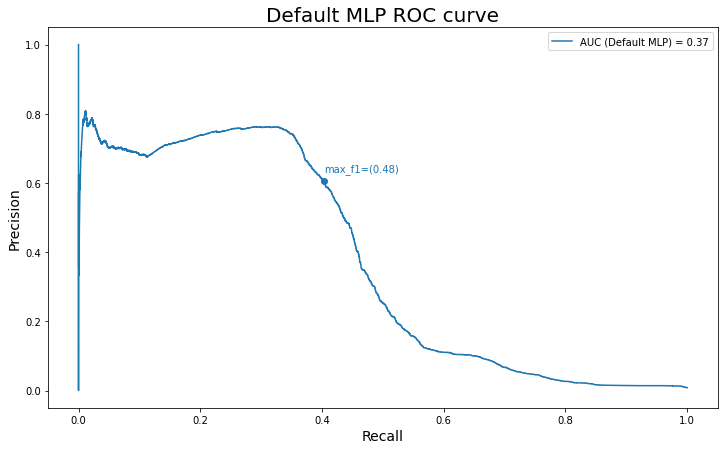

In [19]:
mf.draw_precision_recall_curve([mlp_probs_df], ['Default MLP'], 'Default MLP ROC curve')

# Keras MLP

In [5]:
learning_df = pd.read_csv('test/dfs&results/learning_df.tsv', sep='\t')
X_learning = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_learning = learning_df['y']
groups_learning = learning_df['group_code'].to_numpy()

In [4]:
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneGroupOut
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=9, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

# create the model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)

pipe = Pipeline([
    ('normalize', Normalizer()),
    ('keras_ann', model)
])
logo = LeaveOneGroupOut()

C:\Users\misia\AppData\Local\Temp\ipykernel_10280\1163313088.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)


In [2]:
'''
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
'''

## Load in models from another machine

In [5]:
from joblib import load
results_dnn = load('./test/dnn_res/results_dnn_master.joblib')
path = './test/dnn_res/simple_dnn_models/keras_models/model_'
for i, pipel in enumerate(results_dnn['estimator']):
    pipel.named_steps['keras_ann'].model = keras.models.load_model(path+str(i)+'.h5')

In [11]:
results_dnn['estimator'][0].predict_proba(X_main.iloc[0:3,:].to_numpy())

array([[0.39164376, 0.60835624],
       [0.38938653, 0.61061347],
       [0.39633942, 0.6036606 ]], dtype=float32)